In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import telegram
import pandahouse
from datetime import date
import io
from read_db.CH import Getch
import sys
import os
from scipy.stats import ttest_ind, mannwhitneyu

In [ ]:
# stats.mannwhitneyu(df1.ctr,df2.ctr)
# stats.ttest_ind(df1.ctr,df2.ctr, equal_var=False)

In [85]:
df = Getch('''select user_id, exp_group,
countIf(user_id, action='view') as view_cnt, 
countIf(user_id, action='like') as like_cnt, 
countIf(user_id, action='like')/countIf(user_id, action='view') as ctr 
from simulator_20211220.feed_actions 
where toDate(time) between '2021-12-08' and '2021-12-14'
and exp_group in (2,3)
group by user_id, exp_group
''').df

df

,user_id,exp_group,view_cnt,like_cnt,ctr
0,115383,3,36,11,0.305556
1,123580,3,92,15,0.163043
2,131473,2,148,26,0.175676
3,23985,2,66,12,0.181818
4,24523,2,120,17,0.141667
...,...,...,...,...,...
17044,122008,3,31,4,0.129032
17045,25383,2,57,16,0.280702
17046,122190,3,74,25,0.337838
17047,108927,2,33,8,0.242424


In [9]:
def get_global_ctr(ctr_data, n_samples=5000):
    global_ctr_data = []
    for i in range(n_samples):
        resample_data = ctr_data.sample(frac=0.5, replace=True)
        global_ctr = resample_data.like_cnt.sum() / resample_data.view_cnt.sum()
        global_ctr_data.append(global_ctr)
        
    sns.displot(global_ctr_data)
    
    return [
    pd.Series(global_ctr_data).quantile(0.05),
    pd.Series(global_ctr_data).mean,
    pd.Series(global_ctr_data).quantile(0.95)
    ]

[0.20958951358944952,
 <bound method NDFrame._add_numeric_operations.<locals>.mean of 0       0.211834
 1       0.211425
 2       0.214152
 3       0.209925
 4       0.212321
           ...   
 4995    0.211114
 4996    0.210851
 4997    0.211539
 4998    0.210465
 4999    0.211108
 Length: 5000, dtype: float64>,
 0.21319534772083973]

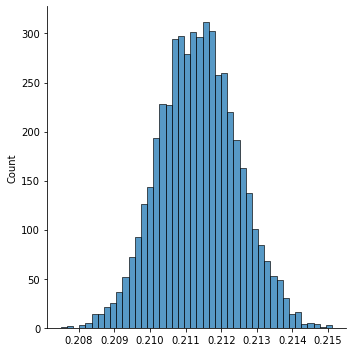

In [13]:
get_global_ctr(df[df.exp_group==2])

## Задание 1

In [ ]:
df = Getch('''select user_id, exp_group,
countIf(user_id, action='view') as view_cnt, 
countIf(user_id, action='like') as like_cnt, 
countIf(user_id, action='like')/countIf(user_id, action='view') as ctr 
from simulator_20211220.feed_actions 
where toDate(time) between '2021-12-08' and '2021-12-14'
and exp_group in (2,3)
group by user_id, exp_group
''').df

df

In [8]:
def get_p_values(ctr_data, group1, group2, n):
    p_values = []
    for i in range(n):
        resample_1 = df[df.exp_group==group1].sample(n=500, replace=True)
        resample_2 = df[df.exp_group==group2].sample(n=500, replace=True)
        p_value = ttest_ind(resample_1.ctr,resample_2.ctr, equal_var=False)
        p_values.append(p_value.pvalue)
    
    sns.displot(p_values, bins=100)
    p_value_share = sum(1 for i in p_values if i<=0.05)/len(p_values)
    if p_value_share <= 0.06:
        msg = 'Система сплитования работает корректно, группы неоднородны в ' + str(round(p_value_share*100,2)) + '% случаев'
    else:
        msg = 'Система сплитования работает некорректно, группы неоднородны в ' + str(round(p_value_share*100,2)) + '% случаев'
        
    return msg

In [27]:
resample_data_g2 = df[df.exp_group==2].sample(n=500, replace=True)
resample_data_g3 = df[df.exp_group==3].sample(n=500, replace=True)
ttest_ind(resample_data_g2.ctr,resample_data_g3.ctr, equal_var=False).pvalue

'Система сплитования работает корректно, группы неоднородны в 5.11% случаев'

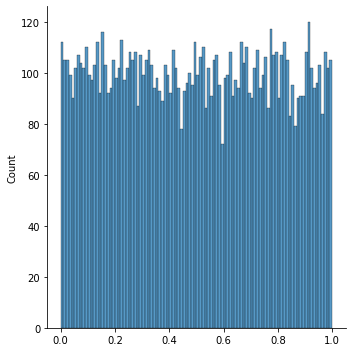

In [9]:
get_p_values(df, 2, 3, 10000)

## Задание 2

In [13]:
df = Getch('''select user_id, exp_group,
countIf(user_id, action='view') as view_cnt, 
countIf(user_id, action='like') as like_cnt, 
countIf(user_id, action='like')/countIf(user_id, action='view') as ctr 
from simulator_20211220.feed_actions 
where toDate(time) between '2021-12-29' and '2022-01-04'
and exp_group in (0,1)
group by user_id, exp_group
''').df

df

,user_id,exp_group,view_cnt,like_cnt,ctr
0,26117,1,21,5,0.238095
1,138232,1,29,5,0.172414
2,49204,1,62,10,0.161290
3,49286,1,19,7,0.368421
4,145957,1,129,54,0.418605
...,...,...,...,...,...
25994,3681,0,28,6,0.214286
25995,110956,1,63,12,0.190476
25996,132567,1,66,18,0.272727
25997,30872,1,82,25,0.304878


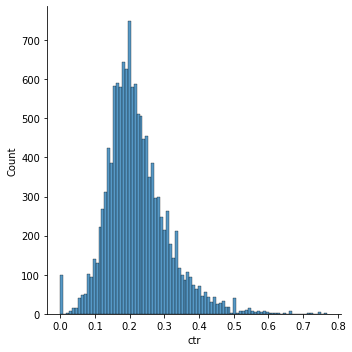

In [14]:
sns.displot(df[df.exp_group==0].ctr)

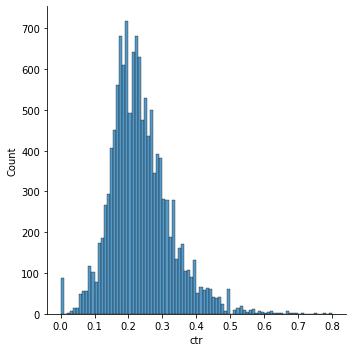

In [15]:
sns.displot(df[df.exp_group==1].ctr)

### Let's smooth ctr

In [15]:
# НАДО ДЛЯ КАЖДОЙ ГРУППЫ

def get_smoothed_ctr(like_cnt, view_cnt, global_ctr, alpha):
    ctr_smoothed = (like_cnt + alpha*global_ctr) / (view_cnt + alpha)
    return ctr_smoothed

In [16]:
global_ctr = df.like_cnt.sum() / df.view_cnt.sum()
df['ctr_smoothed'] = df.apply(lambda x: get_smoothed_ctr(x['like_cnt'], x['view_cnt'], global_ctr, 5), axis=1)
df

,user_id,exp_group,view_cnt,like_cnt,ctr,ctr_smoothed
0,26117,1,21,5,0.238095,0.234903
1,138232,1,29,5,0.172414,0.179632
2,49204,1,62,10,0.161290,0.165783
3,49286,1,19,7,0.368421,0.337812
4,145957,1,129,54,0.418605,0.411250
...,...,...,...,...,...,...
25994,3681,0,28,6,0.214286,0.215378
25995,110956,1,63,12,0.190476,0.192757
25996,132567,1,66,18,0.272727,0.269120
25997,30872,1,82,25,0.304878,0.300086


Mean =  0.22095848556207223


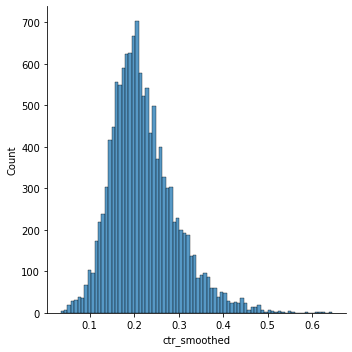

In [49]:
print('Mean = ', df[df.exp_group==0]['ctr_smoothed'].mean())
sns.displot(df[df.exp_group==0].ctr_smoothed)

Mean =  0.234139241899461


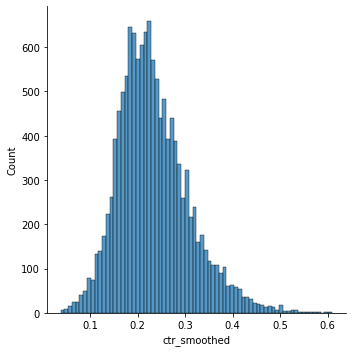

In [50]:
print('Mean = ', df[df.exp_group==1]['ctr_smoothed'].mean())
sns.displot(df[df.exp_group==1].ctr_smoothed)

## Сравниваем две выборки (т-тестом, есть ли различия)

In [73]:
def check_effect(smoothed_ctr_data, group1, group2):
    p_value = ttest_ind(smoothed_ctr_data[smoothed_ctr_data.exp_group==group1].ctr_smoothed, smoothed_ctr_data[smoothed_ctr_data.exp_group==group2].ctr_smoothed, equal_var=False).pvalue
    diff = (smoothed_ctr_data[smoothed_ctr_data.exp_group==group2].ctr_smoothed.mean() - smoothed_ctr_data[smoothed_ctr_data.exp_group==group1].ctr_smoothed.mean()) / smoothed_ctr_data[smoothed_ctr_data.exp_group==group1].ctr_smoothed.mean() *100
    if p_value<0.05:
        msg = 'Эффект от внедрения нового алгоритма присутствует, CTR увеличился на ' + str(round(diff,2)) + '%'
    else:
        msg = 'Эффект от внедрения нового алгоритма обнаружить не удалось'
    print(msg)

In [74]:
check_effect(df, 0, 1)

Эффект от внедрения нового алгоритма присутствует, CTR увеличился на 5.97%


## Сравниваем две выборки по метрике просмотров (не должно быть различий)

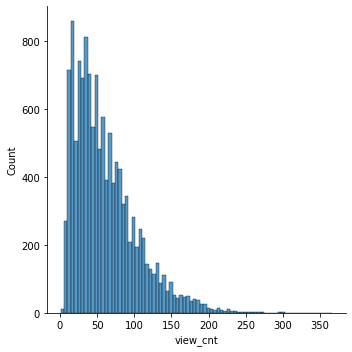

In [75]:
sns.displot(df[df.exp_group==0].view_cnt)

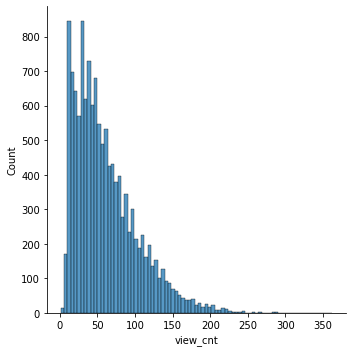

In [76]:
sns.displot(df[df.exp_group==1].view_cnt)

In [78]:
mannwhitneyu(df[df.exp_group==0].view_cnt,df[df.exp_group==1].view_cnt)

MannwhitneyuResult(statistic=84514942.0, pvalue=0.9717276363684261)

In [81]:
def check_secondary_metric(data, group1, group2):
    p_value = mannwhitneyu(data[data.exp_group==group1].view_cnt,data[data.exp_group==group2].view_cnt).pvalue
    diff = (data[data.exp_group==group2].view_cnt.mean() - data[data.exp_group==group1].view_cnt.mean()) / data[data.exp_group==group1].view_cnt.mean() *100
    if p_value<0.05:
        msg = 'Новый алгоритм повлиял на вторичную метрику Views, она изменилась на ' + str(round(diff,2)) + '%'
    else:
        msg = 'Новый алгоритм не повлиял на значение вторичной метрики Views'
    print(msg)

In [82]:
check_secondary_metric(df, 0, 1)

Новый алгоритм не повлиял на значение вторичной метрики Views


#### Задание 3

In [3]:
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis 
rA = 0.7
dr = 0.25
rB = rA+dr

r = (rA+rB)/2

pooled_var = 2*r*(1-r) # rA*(1-rA) + rB*(1-rB)
effect_size = dr/np.sqrt(pooled_var)

alpha = 0.05
power = 0.8  #
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Effect size: {:.2f}, and sample Size: {:.2f}'.format(effect_size,result))

Effect size: 0.47, and sample Size: 73.50


In [12]:
from statsmodels.stats.power import TTestIndPower

effect_size = 0.3
alpha = 0.05
power = 0.8 



analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)

print('Sample size: {:.2f}'.format(result))

Effect size: 0.30, and sample size: 175.38


In [37]:
n1 = len(df[df.exp_group==0])        # number of observations of sample 1
n2 = len(df[df.exp_group==1])         # number of observations of sample 2
mi1 = df[df.exp_group==0].ctr_smoothed.mean()       # mean of sample 1
mi2 = df[df.exp_group==1].ctr_smoothed.mean()     # mean of sample 2
sigma1 = df[df.exp_group==0].ctr_smoothed.std()     # standard deviation of sample 1
sigma2 = df[df.exp_group==1].ctr_smoothed.std()     # standard deviation of sample 2
alpha = 0.05   # significance level


sd_pooled = np.sqrt(((n2 - 1)*sigma2**2 + (n1 - 1)*sigma1**2)/(n1 + n2 - 2))
effect_size = (mi2 - mi1)/sd_pooled

print('Effect size: {:.2f}'.format(effect_size))

Effect size: 0.18


In [38]:
alpha = 0.05
power = 0.8 


# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample size: {:.2f}'.format(result))

Sample size: 501.42


In [ ]:
Для получения effect size = 0.18 можно было использовать меньший объем выборки.